In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as o
import geotorch


DEVICE = None
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.solvers import OTSolver
from src.plotters import SimplePlotter, plot_samples
from src.utils import *

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport", entity="_devourer_")

In [3]:
class CircleCurve:
    def __init__(self, center=0., radius=1.):
        self.center = center
        self.radius = radius

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        x = torch.cos(2 * torch.pi * t) * self.radius + self.center
        y = torch.sin(2 * torch.pi * t) * self.radius + self.center
        return torch.stack([x, y], dim=-1)

class LineCurve:
    def __init__(self, start=torch.tensor([-1., 0.]), end=torch.tensor([1., 0.])):
        self.start = start
        self.end = end

    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        x = t * (self.end[0] - self.start[0]) + self.start[0]
        y = t * (self.end[1] - self.start[1]) + self.start[1]
        return torch.stack([x, y], dim=-1)

In [4]:
def get_explicit_P(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    P = torch.einsum("ij,ik->jk", y, x)
    return P / torch.norm(P)


class InnerGW:
    def __init__(self, l=.05):
        self.l = l

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        P = get_explicit_P(x, y)
        return self.l * torch.norm(x @ P.T - y, 2, dim=1) ** 2


class InnerGW_opt:
    def __init__(self, p, q, l=.05,
                 n_iter=10,
                 optimizer=o.Adam,
                 optimizer_params=dict(lr=5e-5, betas=(.0, .9)),
                 logger=None):
        self.P = nn.Linear(p, q, bias=False)
        geotorch.sphere(self.P, "weight")
        self.P_opt = optimizer(self.P.parameters(), **optimizer_params)

        self.l = l
        self.n_iter = n_iter

        self.logger = logger
        self.step = 0

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        for _ in range(self.n_iter):
            self.P_opt.zero_grad()
            Px = self.P(x)
            cost = self.l * (torch.norm(Px - y.detach(), 2, dim=1) ** 2)
            cost.mean().backward()
            self.P_opt.step()
        Px = self.P(x)
        if self.logger:
            with torch.no_grad():
                target_P = get_explicit_P(x, y)
                P_mse = F.mse_loss(self.P.weight, target_P)
                self.logger.log("P MSE", P_mse.item(), 1 + self.step // 15)
            self.step += 1
        return self.l * torch.norm(Px - y, 2, dim=1) ** 2


In [5]:
def run_experiment(source, target, cost, n_iter,
                   plotter, logger=None, **kwargs):
    if logger:
        logger.start()
    try:
        solver = OTSolver(deepcopy(critic), deepcopy(mover), cost=cost,
                          plotter=plotter, logger=logger,
                          **kwargs)
        solver.fit(source, target, n_iter)
    except KeyboardInterrupt:
        pass
    finally:
        if logger:
            logger.finish()
    return solver

## GMM

### 3D to 2D

In [6]:
p, q = 3, 2
n_neurons = 64

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

In [49]:
n_components = 10

locs_3d = fibonacci_sphere(n_components)
scales_3d = .02 * torch.ones(n_components, p)
source = gaussian_mixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .02 * torch.ones(n_components, q)
target = gaussian_mixture(locs_2d, scales_2d)


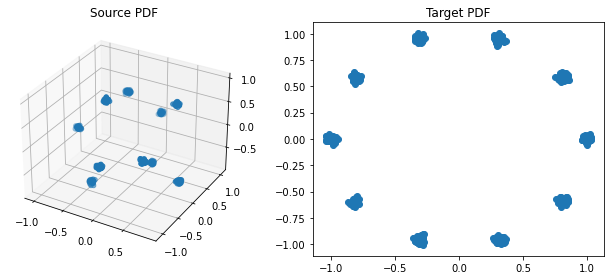

Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [50]:
solver = run_experiment(
    source, target,
    n_iter=2500,
    n_samples=1024,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=3,
        target_dim=2,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
                    # show_progress=False
                    ),
    n_inner_iter=10
)

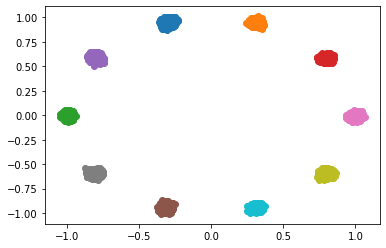

In [51]:
samples_3d = sample_from_gmm_components(source, (5000,))

with torch.no_grad():
    moved_samples = solver.mover(samples_3d)

for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

In [43]:
n_components = 5

locs_3d = fibonacci_sphere(n_components)
scales_3d = .05 * torch.ones(n_components, p)
source = gaussian_mixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .05 * torch.ones(n_components, q)
target = gaussian_mixture(locs_2d, scales_2d)


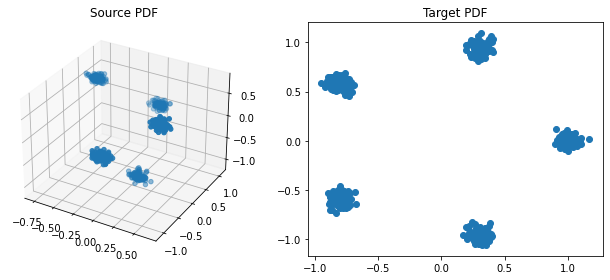

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

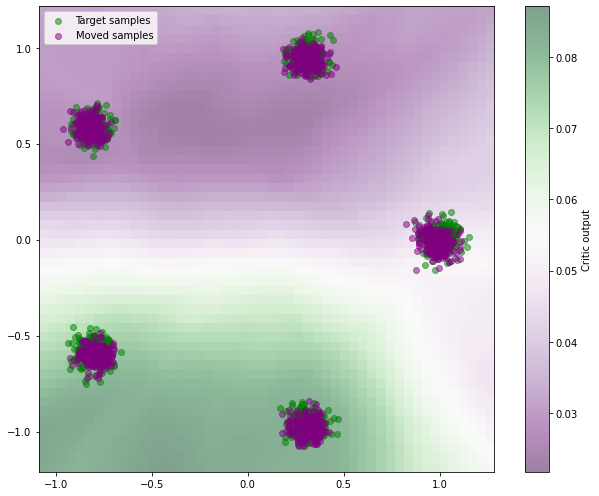

In [46]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=1024,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_lims=((-1, 1), (-1, 1)),
        target_lims=((-1, 1), (-1, 1)),
        pdf_params=dict(n_points=500)
                    # show_progress=False
                    ),
    n_inner_iter=10
)

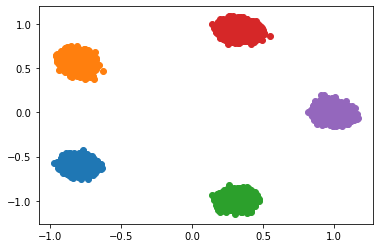

In [47]:
samples_3d = sample_from_gmm_components(source, (5000,))

with torch.no_grad():
    moved_samples = solver.mover(samples_3d)

for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

In [29]:
n_components = 10

locs_3d = fibonacci_sphere(n_components)
scales_3d = .15 * torch.ones(n_components, p)
source = gaussian_mixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .15 * torch.ones(n_components, q)
target = gaussian_mixture(locs_2d, scales_2d)

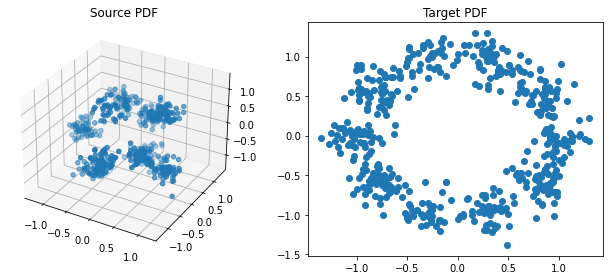

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

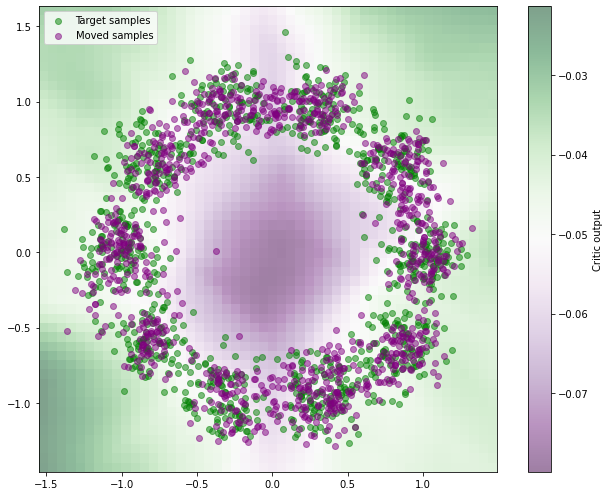

In [30]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=1024,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=3,
        target_dim=2,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
                    # show_progress=False
                    ),
    n_inner_iter=10
)

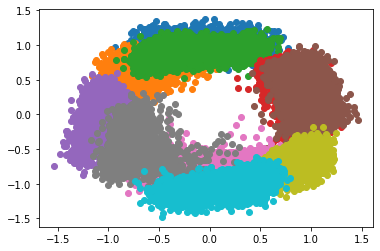

In [31]:
samples_3d = sample_from_gmm_components(source, (5000,))

with torch.no_grad():
    moved_samples = solver.mover(samples_3d)

for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

In [7]:
n_components = 10

locs_3d = fibonacci_sphere(n_components)
scales_3d = .3 * torch.ones(n_components, p)
source = gaussian_mixture(locs_3d, scales_3d)

locs_2d = uniform_circle(n_components)
scales_2d = .3 * torch.ones(n_components, q)
target = gaussian_mixture(locs_2d, scales_2d)

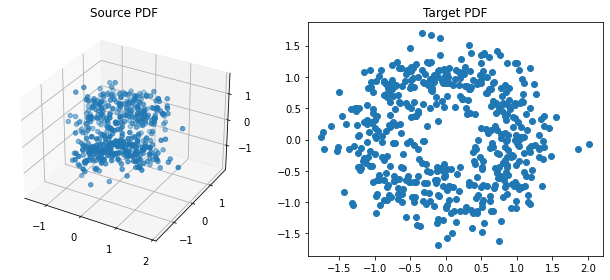

Output()

  0%|          | 0/1000 [00:00<?, ?it/s]

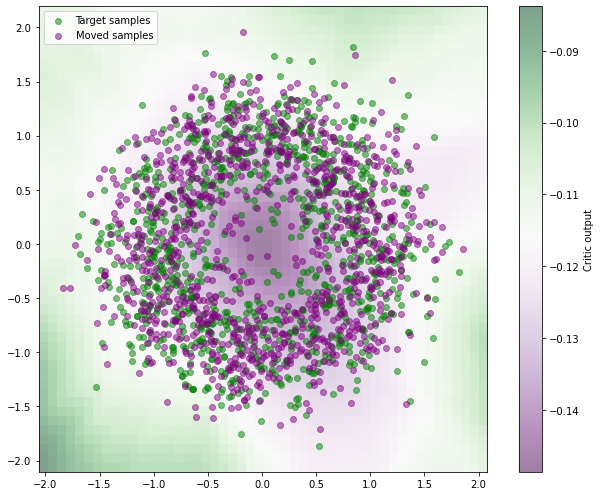

In [9]:
solver = run_experiment(
    source, target,
    n_iter=1000,
    n_samples=1024,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=3,
        target_dim=2,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
                    # show_progress=False
                    ),
    n_inner_iter=10
)

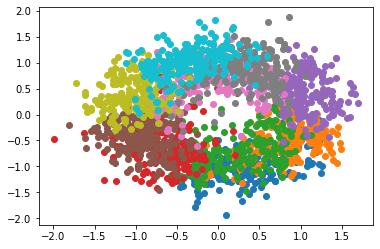

In [12]:
samples_3d = sample_from_gmm_components(source, (200,))

with torch.no_grad():
    moved_samples = solver.mover(samples_3d)

for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

### 2D to 3D

In [6]:
p, q = 2, 3
n_neurons = 64

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

In [13]:
n_components = 7

locs_2d = uniform_circle(n_components)
scales_2d = .02 * torch.ones(n_components, p)
source = gaussian_mixture(locs_2d, scales_2d)

locs_3d = fibonacci_sphere(n_components)
scales_3d = .02 * torch.ones(n_components, q)
target = gaussian_mixture(locs_3d, scales_3d)


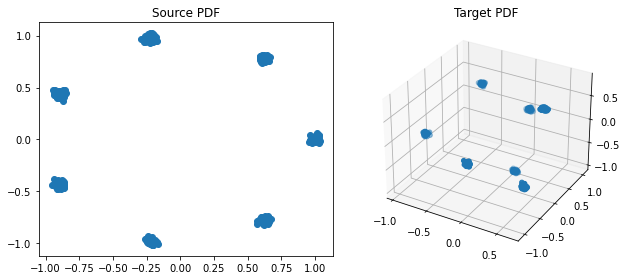

Output()

  0%|          | 0/2500 [00:00<?, ?it/s]

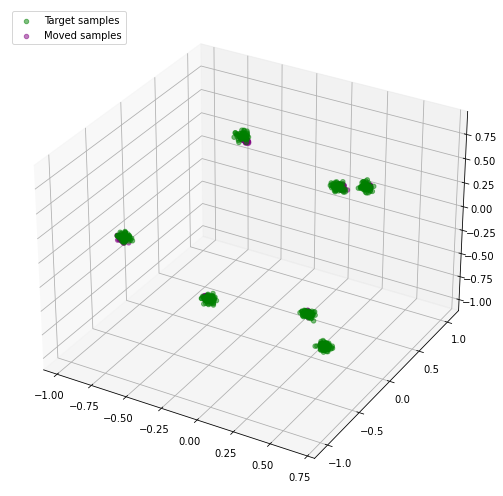

In [14]:
solver = run_experiment(
    source, target,
    n_iter=2500,
    n_samples=512,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_lims=((-1, 1), (-1, 1)),
        target_lims=((-1, 1), (-1, 1)),
        pdf_params=dict(n_points=500)
                    # show_progress=False
                    ),
    n_inner_iter=5
)

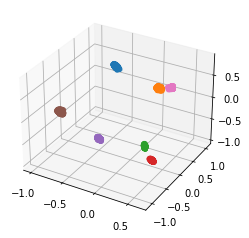

In [15]:
samples_2d = sample_from_gmm_components(source, (5000,))

with torch.no_grad():
    moved_samples = solver.mover(samples_2d)

for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

In [7]:
n_components = 7

locs_2d = uniform_circle(2 * n_components)
scales_2d = .2 * torch.ones(2 * n_components, p)
source = gaussian_mixture(locs_2d, scales_2d)

locs_3d = fibonacci_sphere(n_components)
scales_3d = .2 * torch.ones(n_components, q)
target = gaussian_mixture(locs_3d, scales_3d)


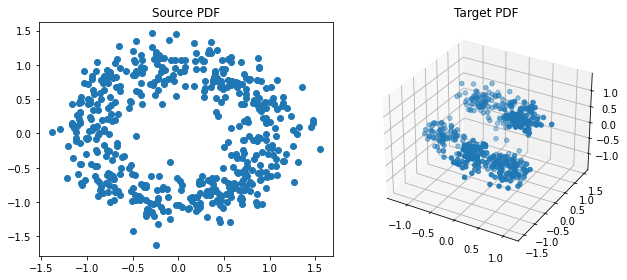

Output()

  0%|          | 0/2000 [00:00<?, ?it/s]

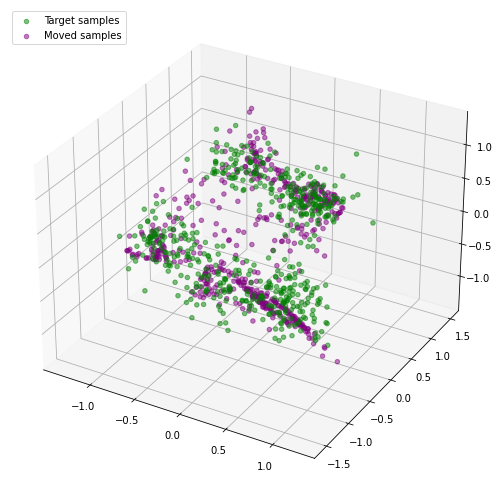

In [9]:
solver = run_experiment(
    source, target,
    n_iter=2000,
    n_samples=512,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=p,
        target_dim=q,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
    # show_progress=False
    ),
    n_inner_iter=5
)

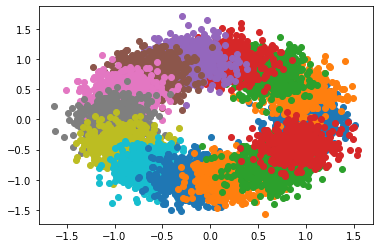

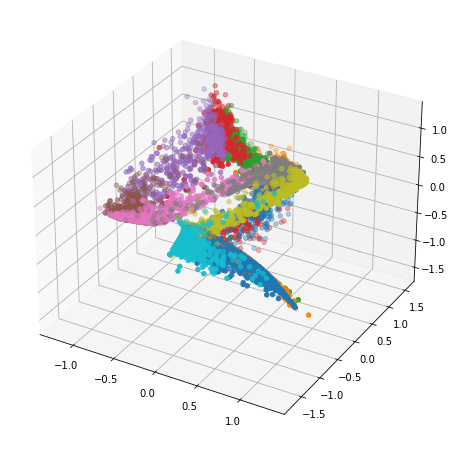

In [10]:
samples_2d = sample_from_gmm_components(source, (500,))

for samples_batch in samples_2d:
    plot_samples(samples_batch)
plt.show()

with torch.no_grad():
    moved_samples = solver.mover(samples_2d)

plt.figure(figsize=(10, 8))
for samples_batch in moved_samples:
    plot_samples(samples_batch)
plt.show()

In [11]:
p = q = 2
n_neurons = 256

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = nn.Sequential(
    nn.Linear(p, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(),
    nn.Linear(n_neurons, q)
)

In [12]:
source = CurveDistribution(LineCurve(start=(-2, 0), end=(2, 0)))
target = Normal(torch.zeros(2), torch.ones(2))

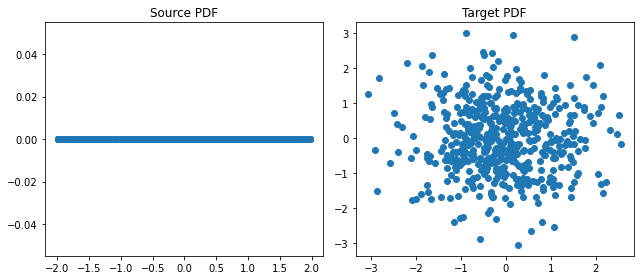

Output()

  0%|          | 0/5000 [00:00<?, ?it/s]

In [13]:
solver = run_experiment(
    source, target,
    n_iter=5000,
    n_samples=1024,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=p,
        target_dim=q,
        pdf_params=dict(
            n_points=500,
            source_lims=((-1, 1), (-1, 1)),
            target_lims=((-1, 1), (-1, 1)),
        )
                    # show_progress=False
                    ),
    n_inner_iter=10
)